In [24]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/asl-fingerspelling/supplemental_metadata.csv
/kaggle/input/asl-fingerspelling/character_to_prediction_index.json
/kaggle/input/asl-fingerspelling/train.csv
/kaggle/input/asl-fingerspelling/supplemental_landmarks/371169664.parquet
/kaggle/input/asl-fingerspelling/supplemental_landmarks/369584223.parquet
/kaggle/input/asl-fingerspelling/supplemental_landmarks/1682915129.parquet
/kaggle/input/asl-fingerspelling/supplemental_landmarks/775880548.parquet
/kaggle/input/asl-fingerspelling/supplemental_landmarks/2100073719.parquet
/kaggle/input/asl-fingerspelling/supplemental_landmarks/1650637630.parquet
/kaggle/input/asl-fingerspelling/supplemental_landmarks/1471096258.parquet
/kaggle/input/asl-fingerspelling/supplemental_landmarks/86446671.parquet
/kaggle/input/asl-fingerspelling/supplemental_landmarks/897287709.parquet
/kaggle/input/asl-fingerspelling/supplemental_landmarks/333606065.parquet
/kaggle/input/asl-fingerspelling/supplemental_landmarks/2057261717.parquet
/kaggle/inpu

In [25]:
!pip install mediapipe


### Importing all the necessary libraries

In [26]:
import os
import shutil
import numpy as np
import pandas as pd
import pyarrow.parquet as pq
import tensorflow as tf
import json
import mediapipe
import matplotlib
import matplotlib.pyplot as plt
import random

from skimage.transform import resize
from mediapipe.framework.formats import landmark_pb2
from tensorflow import keras
from tensorflow.keras import layers
from tqdm.notebook import tqdm
from matplotlib import animation, rc


### Loading the dataset

In [27]:
data = pd.read_csv('/kaggle/input/asl-fingerspelling/train.csv')
print("Full train dataset shape is {}".format(data.shape))

Full train dataset shape is (67208, 5)


In [5]:
data.head()

,path,file_id,sequence_id,participant_id,phrase
0,train_landmarks/5414471.parquet,5414471,1816796431,217,3 creekhouse
1,train_landmarks/5414471.parquet,5414471,1816825349,107,scales/kuhaylah
2,train_landmarks/5414471.parquet,5414471,1816909464,1,1383 william lanier
3,train_landmarks/5414471.parquet,5414471,1816967051,63,988 franklin lane
4,train_landmarks/5414471.parquet,5414471,1817123330,89,6920 northeast 661st road


### Now let us understand the dataset and how all the files are linked to each other

### Train.csv has an entry for every phrase along with its sequence_id, path, and file_id. The sequence_id is the unique index of the landmark sequence within the landmarks data file, and file_id specifies the file containing the landmarks data for that specific phrase.

### The diagram that follows provides an illustration of how files are related.

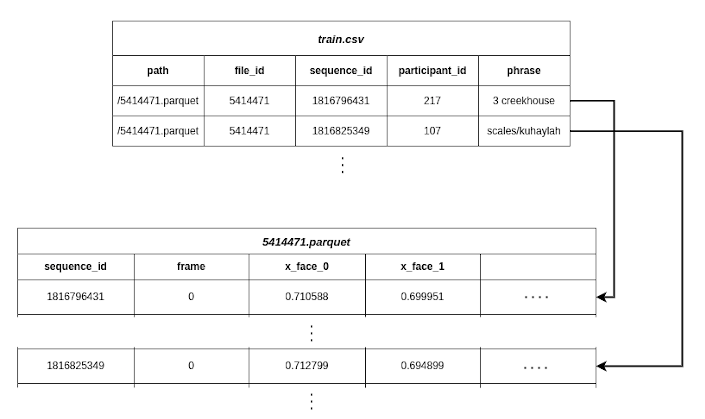


### Now we will examine one example row from landmark file and how it is related with train.csv

In [28]:
# Fetch sequence_id, file_id, phrase from 7th row
sequence_id, file_id, phrase = data.iloc[6][['sequence_id', 'file_id', 'phrase']]
print(f"sequence_id: {sequence_id}, file_id: {file_id}, phrase: {phrase}")

sequence_id: 1817169529, file_id: 5414471, phrase: https://jsi.is/hukuoka


### Now next we can access the parquet file for particular sequence id in the following manner 

In [29]:
# Fetch data from parquet file
sample_sequence_df = pq.read_table(f"/kaggle/input/asl-fingerspelling/train_landmarks/{str(file_id)}.parquet",
    filters=[[('sequence_id', '=', sequence_id)],]).to_pandas()
print("Full sequence dataset shape is {}".format(sample_sequence_df.shape))

Full sequence dataset shape is (300, 1630)


In [30]:
# Now let us this sample_sequence_df 
sample_sequence_df.head()

,frame,x_face_0,x_face_1,x_face_2,x_face_3,x_face_4,x_face_5,x_face_6,x_face_7,x_face_8,...,z_right_hand_11,z_right_hand_12,z_right_hand_13,z_right_hand_14,z_right_hand_15,z_right_hand_16,z_right_hand_17,z_right_hand_18,z_right_hand_19,z_right_hand_20
sequence_id,,,,,,,,,,,,,,,,,,,,,
1817169529,0,0.740435,0.734038,0.737507,0.723142,0.733195,0.733479,0.735043,0.653469,0.734492,...,-0.327317,-0.358946,-0.205048,-0.289102,-0.316426,-0.330475,-0.224326,-0.283333,-0.297210,-0.305664
1817169529,1,0.743968,0.731306,0.734982,0.720691,0.730481,0.730834,0.732612,0.651775,0.732095,...,-0.280167,-0.301074,-0.174787,-0.245952,-0.250015,-0.244606,-0.193371,-0.238736,-0.233796,-0.225342
1817169529,2,0.735330,0.727608,0.731663,0.717006,0.726665,0.727005,0.728827,0.648945,0.728236,...,-0.262822,-0.280881,-0.170362,-0.222043,-0.208816,-0.195668,-0.187259,-0.210144,-0.189974,-0.174090
1817169529,3,0.741500,0.724301,0.728569,0.714643,0.723468,0.724143,0.726969,0.648704,0.726976,...,-0.164224,-0.172994,-0.124070,-0.154734,-0.138793,-0.125200,-0.137634,-0.151121,-0.132724,-0.118861
1817169529,4,0.738992,0.729264,0.733287,0.718563,0.728307,0.728631,0.730391,0.650175,0.729882,...,-0.161075,-0.168983,-0.120189,-0.148746,-0.126287,-0.107934,-0.134492,-0.145703,-0.122515,-0.104440


In [31]:
# Now let us this sample_sequence_df 
sample_sequence_df.head()

,frame,x_face_0,x_face_1,x_face_2,x_face_3,x_face_4,x_face_5,x_face_6,x_face_7,x_face_8,...,z_right_hand_11,z_right_hand_12,z_right_hand_13,z_right_hand_14,z_right_hand_15,z_right_hand_16,z_right_hand_17,z_right_hand_18,z_right_hand_19,z_right_hand_20
sequence_id,,,,,,,,,,,,,,,,,,,,,
1817169529,0,0.740435,0.734038,0.737507,0.723142,0.733195,0.733479,0.735043,0.653469,0.734492,...,-0.327317,-0.358946,-0.205048,-0.289102,-0.316426,-0.330475,-0.224326,-0.283333,-0.297210,-0.305664
1817169529,1,0.743968,0.731306,0.734982,0.720691,0.730481,0.730834,0.732612,0.651775,0.732095,...,-0.280167,-0.301074,-0.174787,-0.245952,-0.250015,-0.244606,-0.193371,-0.238736,-0.233796,-0.225342
1817169529,2,0.735330,0.727608,0.731663,0.717006,0.726665,0.727005,0.728827,0.648945,0.728236,...,-0.262822,-0.280881,-0.170362,-0.222043,-0.208816,-0.195668,-0.187259,-0.210144,-0.189974,-0.174090
1817169529,3,0.741500,0.724301,0.728569,0.714643,0.723468,0.724143,0.726969,0.648704,0.726976,...,-0.164224,-0.172994,-0.124070,-0.154734,-0.138793,-0.125200,-0.137634,-0.151121,-0.132724,-0.118861
1817169529,4,0.738992,0.729264,0.733287,0.718563,0.728307,0.728631,0.730391,0.650175,0.729882,...,-0.161075,-0.168983,-0.120189,-0.148746,-0.126287,-0.107934,-0.134492,-0.145703,-0.122515,-0.104440


### Visualizing data with mediapipe APIs
### Let's utilize the hand landmarker apis of the mediapipe library to visualize the hand landmarks data for the phrase 3 Creek House.

### The main digits on a human hand are represented by hand landmarks.

In [32]:
import matplotlib.pyplot as plt
from matplotlib import animation, rc

# Set matplotlib parameters
plt.rcParams['animation.embed_limit'] = 2**128
plt.rcParams['savefig.pad_inches'] = 0
rc('animation', html='jshtml')

def create_image_animation(image_list):
    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(6, 9))
    ax.set_axis_off()

    # Display the first image
    im = ax.imshow(image_list[0], cmap="gray")
    plt.close(fig)

    # Define the animation function
    def animate_frame(frame_idx):
        im.set_array(image_list[frame_idx])
        return [im]

    # Create and return the animation
    animation_obj = animation.FuncAnimation(fig, animate_frame, frames=len(image_list), interval=1000/10)
    return animation_obj
